# Данные

In [2]:
import pandas as pd
from pymorphy2 import MorphAnalyzer
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
import fastText
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import *
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [1]:
file = 'ML-for-compling/data/vk_texts_with_sources.csv'
df = pd.read_csv(file, usecols = ['text', 'source'])
df.head()

# Домашнее задание 1 

В этом домашнем задании вы будете решать задачу тематической классификации. Даны тексты, опубликованные в нескольких пабликах VK.com, посвященных государственным и муниципальным службам. Формально задача заключается в том, чтобы по тексту ($d$) определить в каком паблике он опубликован, то есть, к какому классу $c$ он принадлежит. 

## Задание 1 [2 балла]. Описательные статистики
Посчитайте:
* количество текстов и количество классов
* количество слов (без лемматизации и с лемматизацией) в коллекции
* среднюю длину текста в словах и символах
* найдите 5 самых частых существительных в текстах каждого паблика 

*Рекомендуем использовать pandas для расчета описательных статистик.*

In [3]:
def lemmatize(entry):
    morph = MorphAnalyzer()
    punctte = punctuation+'«»—…“”*№§'
    words = [word.strip(punctte) for word in entry.lower().split()]
    wordslemma = []
    wordspos = []
    for word in words:
        wordslemma.append(morph.parse(word)[0].normal_form)
        wordspos.append(str(morph.parse(word)[0].tag.POS))
    return " ".join(wordslemma) + "§" + " ".join(wordspos)

    
def nostops(entry):
    stops = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
    entry = [x for x in entry.split() if x not in stops]
    return " ".join(entry)

def wordcounter(entry):
    count = 0
    for word in entry.split():
        count += 1
    return count
    
def poscounter (df, partofspeech):
    groupedf = df.groupby("source")
    finalcount = []
    for group in groupedf:
        countcounter = []
        wordlist = []
        poslist = []
        counter = []
        wordlistunpack = group[1]['lemmatizedtext'].str.split().tolist()
        for listing in wordlistunpack:
            wordlist.append(" ".join(listing))
        wordlistunpack = []
        poslistunpack= group[1]['lemmatizedpos'].str.split().tolist()
        for listing in poslistunpack:
            poslist.append(" ".join(listing))
        poslistunpack = []
        for i, words in enumerate(wordlist):
            words = words.split()
            poss = poslist[i].split()
            wordlistunpack.append([x for i, x in enumerate(words) if poss[i].startswith(partofspeech) and len(x) >= 3])
        countcounter.append([" ".join(listing) for listing in wordlistunpack])
        countcounter = [" ".join(listing) for listing in countcounter]
        counter = Counter(countcounter[0].split()) # fix 'Counter' object is not callable
        finalcount.append((group[0], counter.most_common(5)))
    return finalcount 

In [14]:
# DO NOT RUN AGAIN!!!
df = df.dropna()
df['text'] = df['text'].str.replace("<br>", "")
df['wordcount'] = df['text'].apply(wordcounter)
df['symbolcount'] = df['text'].str.len()
df['lemmatizedtext'] = df['text'].apply(lemmatize)
tempdf = df['lemmatizedtext'].str.split("§", expand=True)
df['lemmatizedtext'] = tempdf.iloc[:,0]
df['lemmatizedpos'] = tempdf.iloc[:,1]
tempdf = []
#save to file to work faster
df.to_csv("lemmatizeddf.csv", sep="\t", encoding="utf-8", index=False)

In [4]:
df = pd.read_csv("lemmatizeddf.csv", header=0, sep="\t")
rows = len(df.index)
domains = len(df.groupby('source'))
wordcount = len(Counter(" ".join(df['text'].astype(str)).split(" ")).items())
lemmacount = len(Counter(" ".join(df['lemmatizedtext']).split(" ")).items())
meanwords = df['wordcount'].mean()
meansymbols = df['symbolcount'].mean()
adjcount_by_group = poscounter(df, "NOUN")

print("количество текстов = " + str(rows) + "\n" + "количество классов = " + str(domains) + "\n" + "количество уникальных слов без лемматизации = " + str(wordcount) + "\n" + "количество уникальных слов с лемматизацией = " + str(lemmacount) + "\n" + "среднюю длину текста в словах = " + str(meanwords) + "\n" + "среднюю длину текста в символах = " + str(meansymbols) + "\n" + "5 самых частых существительных в текстах каждого паблик: ")
print(adjcount_by_group)
        

количество текстов = 11526
количество классов = 4
количество уникальных слов без лемматизации = 134704
количество уникальных слов с лемматизацией = 48291
среднюю длину текста в словах = 84.09682457053619
среднюю длину текста в символах = 667.2919486378622
5 самых частых существительных в текстах каждого паблик: 
[('mchsgov', [('мчс', 3446), ('россия', 1578), ('мчсроссия', 1217), ('спасатель', 565), ('год', 417)]), ('mil', [('военный', 1287), ('минобороны', 1274), ('россия', 1177), ('год', 1004), ('учение', 846)]), ('mospolice', [('полиция', 5360), ('год', 4541), ('москва', 4015), ('россия', 3840), ('мвд', 3601)]), ('russianpost', [('почта', 2801), ('россия', 2442), ('год', 1725), ('письмо', 1280), ('отделение', 1276)])]


Разделите коллекцию текстов на обучающую и тестовую части.

In [5]:
df = shuffle(df)
train, test = train_test_split(df, test_size=0.2)

 ## Задание 2 [2 балла]. Классификация по правилам
 
 * Разработайте несколько правил вида "Если встречается слово $w$, то текст относится к паблику $c$"
 * Посчитайте, какую точность, полноту, $f$-меру и $accuracy$ вы получаете при классификации по правилам
 * Получилось ли у вас придумать правило, которое никогда не ошибается?

In [22]:
# 

def kwclassifier (entries):
    keywordslist = [['мчс','мчсроссия', 'спасатель', 'пожар', 'пожарный', 'спасательный', 'половодье', 'спасли', 'взрыв'], ['военный', 'минобороны','боевой', 'обороны', 'корабли', 'война', 'танк', 'армия', 'авиация',], ['полиция', 'мвд', 'кража', 'задержали', 'коррупции', 'полицейский', 'наркотики', 'грабеж', 'омвд'], ['почта', 'письмо', 'открытка', 'марка', 'филателисты', 'писатель', 'подписку', 'переписке', 'почтовый']]
    classdict = { 0 : "mchsgov", 1 : "mil", 2 : "mospolice", 3 : "russianpost"}
    classlist = []
    for entry in entries:
        entry = nostops(entry).split()
        counter = 0
        maxcounter = 0
        index = 0
        for i, list in enumerate(keywordslist):
            for word in entry:
                if word in list:
                    counter += 1
            if counter > maxcounter:
                maxcounter = counter
                index = i
        classlist.append(classdict[index])
    return classlist

classes = kwclassifier(test['lemmatizedtext'])
trueclasses = test['source'].tolist()
print(classification_report(trueclasses, classes))

              precision    recall  f1-score   support

     mchsgov       0.69      0.93      0.79       607
         mil       0.93      0.64      0.76       578
   mospolice       0.96      0.93      0.94       603
 russianpost       0.92      0.90      0.91       518

   micro avg       0.85      0.85      0.85      2306
   macro avg       0.87      0.85      0.85      2306
weighted avg       0.87      0.85      0.85      2306



не лемматизировать слова это самая большая проблема классификации по правилам, а даже совпадения структуры текста (в mospolice - у всех текстов hastags mчс, полиция, которые помогают получить хорошие резултаты. Резултаты точности не плохие (кроме mchsgov), но не достаточно хорошие.

## Задание 3 [4 балла]. Baseline
Используйте стандартный ```sklearn.pipeline``` для классификации текстов: 
* векторизация 
* $tf-idf$ взвешивание 
* ваш любимый метод классификации.


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

              precision    recall  f1-score   support

     mchsgov       0.99      0.93      0.96       574
         mil       0.98      0.97      0.98       612
   mospolice       0.96      0.99      0.98       595
 russianpost       0.94      0.96      0.95       525

   micro avg       0.97      0.97      0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306



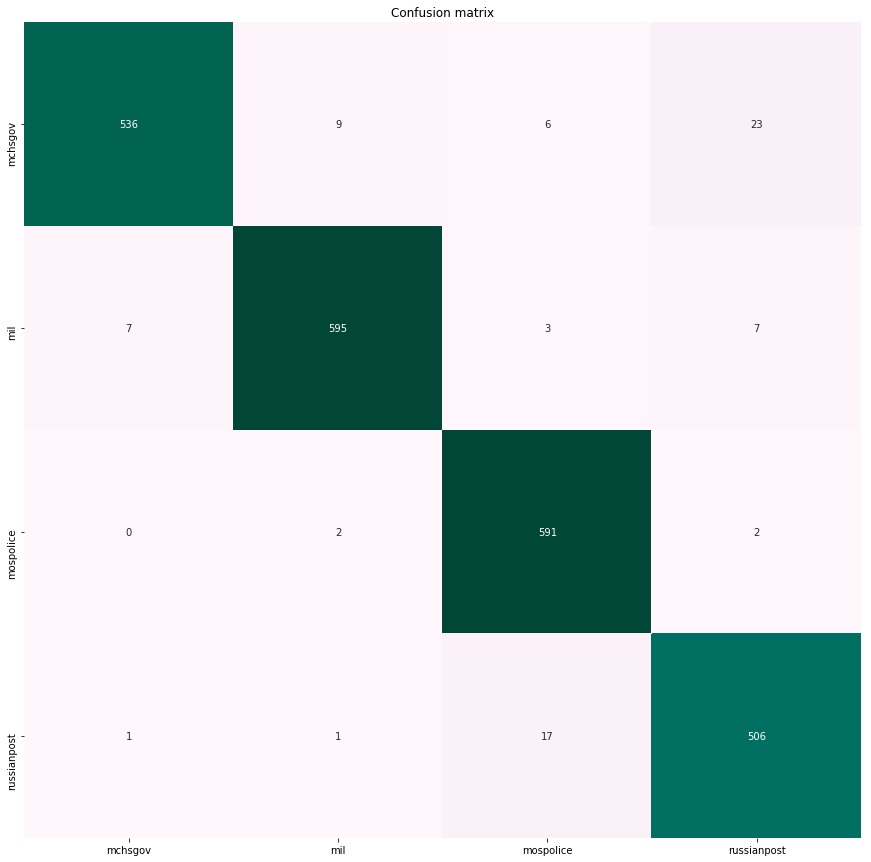

In [7]:
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer="word")
transformer = TfidfTransformer()
classifier = MultinomialNB()

clf = Pipeline([
    ('vect', vectorizer),
    ('tran', transformer),
    ('clf', classifier),
])
clf.fit(train['text'], train['source'])
predictions = clf.predict(test['text'])
print(classification_report(test['source'], predictions))

m = confusion_matrix(test['source'], predictions)

labels = clf.classes_
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Задание 4 [2 балла]. Снижение размерности
Добавьте в ваш ```sklearn.pipeline```  методы снижения размерности:  PCA / LSI / LSA / LDA / другое. Какие методы классификации разумно использовать после снижения размерности? Как изменились результаты классификации после добавления нового шага?

In [9]:
dense = FunctionTransformer(lambda x: x.todense(), accept_sparse=True)
classifier = LinearDiscriminantAnalysis()
clf = Pipeline([
    ('vect', vectorizer),
    ('tran', transformer),
    ('dense', dense),
    ('clf', classifier),
])
clf.fit(train['text'], train['source'])
predictions = clf.predict(test['text'])
print(classification_report(test['source'], predictions))

c:\users\loren\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
c:\users\loren\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\loren\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


              precision    recall  f1-score   support

     mchsgov       0.86      0.97      0.91       574
         mil       0.99      0.91      0.95       612
   mospolice       0.98      0.94      0.96       595
 russianpost       0.92      0.92      0.92       525

   micro avg       0.94      0.94      0.94      2306
   macro avg       0.94      0.94      0.94      2306
weighted avg       0.94      0.94      0.94      2306



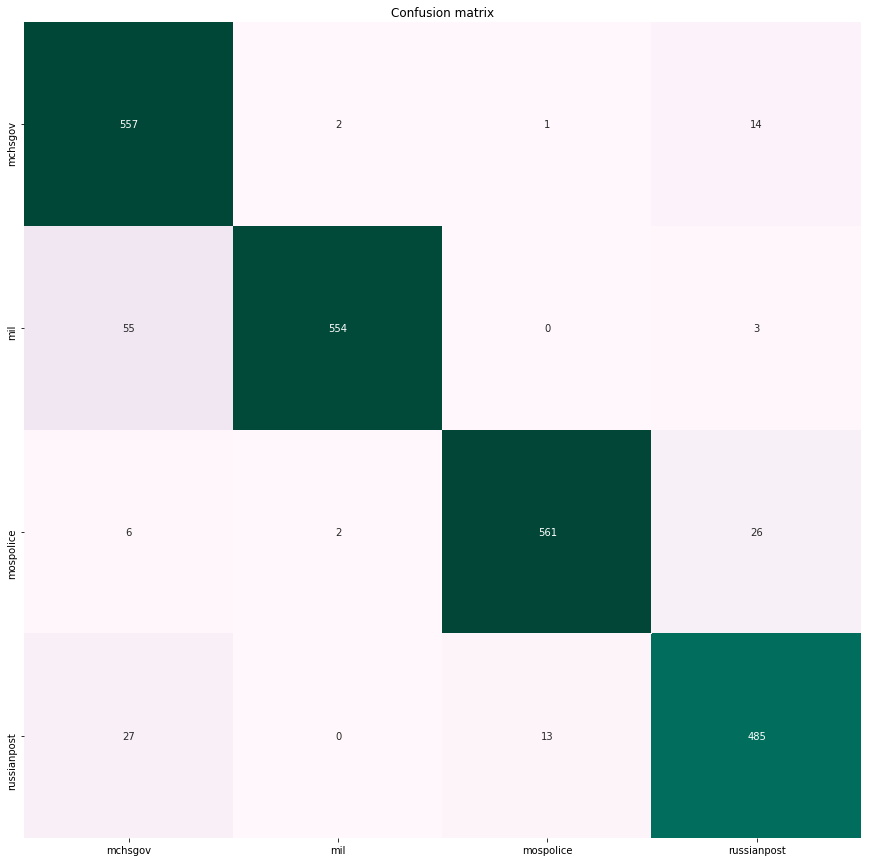

In [10]:
m = confusion_matrix(test['source'], predictions)

labels = clf.classes_
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Задание 5 [2 балла]. Лемматизация
Посмотрите, как влияет лемматизация на качество классификации. Как изменится качество классификации, если вы используете ```CountVectorizer``` на словах или $n$-граммах на лемматизированных 

['mil' 'mil' 'russianpost' ... 'mchsgov' 'mil' 'mospolice']
              precision    recall  f1-score   support

     mchsgov       0.91      0.95      0.93       574
         mil       0.99      0.93      0.96       612
   mospolice       0.98      0.96      0.97       595
 russianpost       0.91      0.95      0.93       525

   micro avg       0.95      0.95      0.95      2306
   macro avg       0.95      0.95      0.95      2306
weighted avg       0.95      0.95      0.95      2306



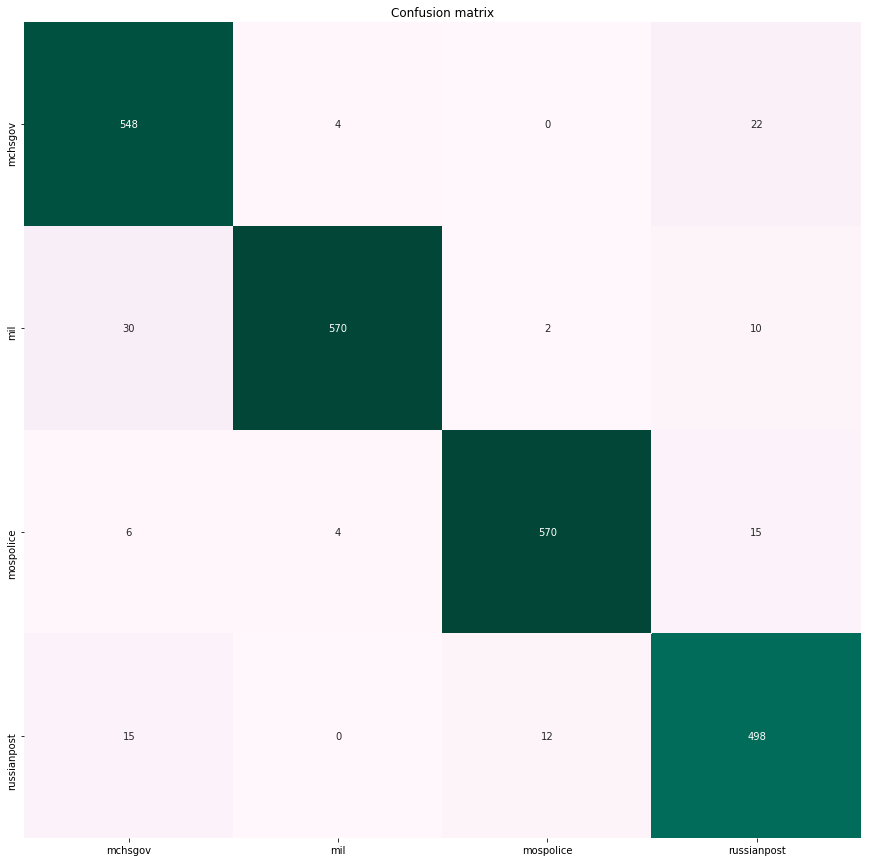

In [40]:
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer="word")
transformer = TfidfTransformer()
classifier = MultinomialNB()

clf = Pipeline([
    ('vect', vectorizer),
    ('tran', transformer),
    ('clf', classifier),
])
clf.fit(train['lemmatizedtext'], train['source'])
predictions = clf.predict(test['lemmatizedtext'])
print(classification_report(test['source'], predictions))

m = confusion_matrix(test['source'], predictions)

labels = clf.classes_
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Задание 6 [4 балла]. Модель скрытых тем
Постройте и визуализируйте модель скрытых тем (LSI или LDA) по данной коллекции текстов. Нужно ли здесь использовать разделение на тестовую и обучающую части? Как модель скрытых тем может помочь в решении задачи классификации?

In [10]:
def build_lda(X_train, y_train, X_test):
    vec = CountVectorizer()
    # sc = StandardScaler()
    X_train = vec.fit_transform(X_train)
    X_test = vec.transform(X_test)
    feature_names = vec.get_feature_names()
    lda = LatentDirichletAllocation(n_components = 4, learning_method='online', random_state=0)
    model = lda.fit(X_train)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return model, feature_names, y_pred

Let's try to transform the train matrix on the test set and see if it works

In [18]:
def display_word_distribution(model, feature_names, n_word):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        words = []
        for i in topic.argsort()[:-n_word - 1:-1]:
            words.append(feature_names[i])
        print(words)

traincorpus = [nostops(x) for x in train['lemmatizedtext']]
lda_model, feature_names, predictions = build_lda(traincorpus, train['source'], test['lemmatizedtext'])
display_word_distribution(
    model=lda_model, feature_names=feature_names,
    n_word=10)
    
cr = classification_report(test['source'], predictions)
print(cr)

Topic 0:
['почтовый', 'почта', 'который', 'письмо', 'свой', 'доставка', 'отделение', 'весь', 'отправление', 'мочь']
Topic 1:
['военный', 'минобороны', 'российский', 'учение', 'оборона', 'сила', 'корабль', 'год', 'россия', 'комплекс']
Topic 2:
['полиция', 'мвд', 'год', 'москва', 'россия', 'сотрудник', 'петровка38', 'гу', 'задержать', 'служба']
Topic 3:
['россия', 'мчс', 'год', 'ru', 'www', 'почтовый', 'http', 'item', 'почта', 'news']
              precision    recall  f1-score   support

     mchsgov       0.66      0.76      0.71       615
         mil       0.94      0.92      0.93       607
   mospolice       0.94      0.97      0.96       563
 russianpost       0.70      0.57      0.63       521

   micro avg       0.81      0.81      0.81      2306
   macro avg       0.81      0.81      0.81      2306
weighted avg       0.81      0.81      0.81      2306



c:\users\loren\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\loren\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


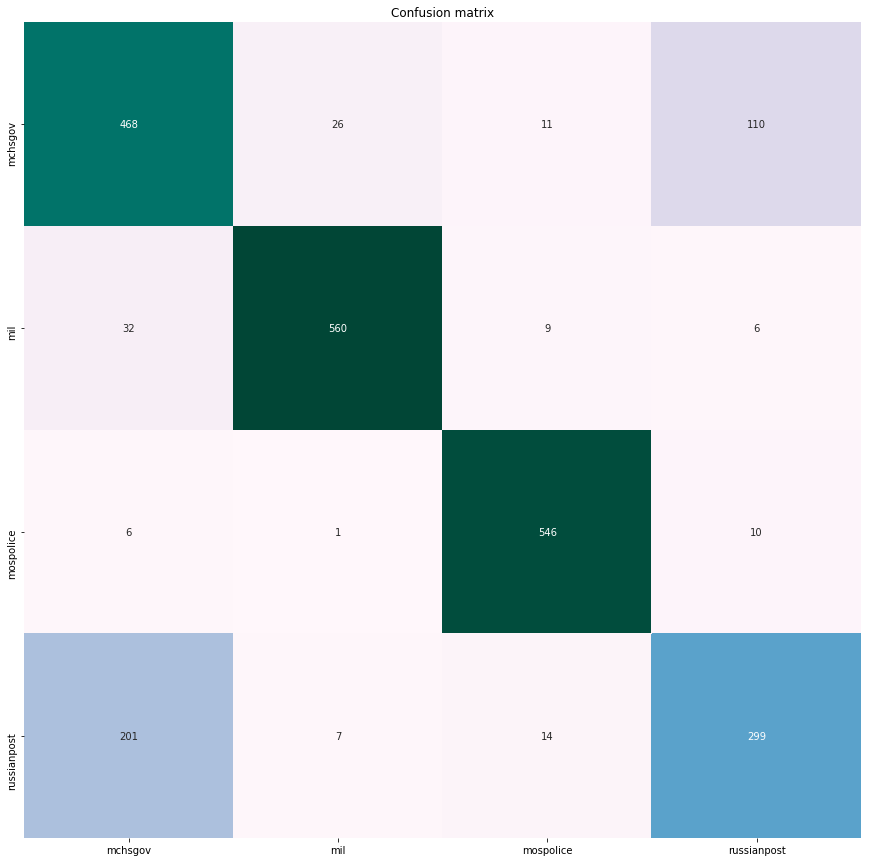

In [23]:
lines = cr.split('\n')
classes = []
for line in lines[2 : (len(lines) - 5)]:
    t = line.split()
    classes.append(t[0])
    
m = confusion_matrix(test['source'], predictions)

labels = classes
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Let's repeat the experiment only on the train set, we do not see big differences.

c:\users\loren\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\loren\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Topic 0:
['почтовый', 'почта', 'который', 'письмо', 'свой', 'доставка', 'отделение', 'весь', 'отправление', 'мочь']
Topic 1:
['военный', 'минобороны', 'российский', 'учение', 'оборона', 'сила', 'корабль', 'год', 'россия', 'комплекс']
Topic 2:
['полиция', 'мвд', 'год', 'москва', 'россия', 'сотрудник', 'петровка38', 'гу', 'задержать', 'служба']
Topic 3:
['россия', 'мчс', 'год', 'ru', 'www', 'почтовый', 'http', 'item', 'почта', 'news']
              precision    recall  f1-score   support

     mchsgov       0.65      0.75      0.70      2409
         mil       0.95      0.92      0.94      2410
   mospolice       0.94      0.96      0.95      2291
 russianpost       0.68      0.56      0.62      2110

   micro avg       0.81      0.81      0.81      9220
   macro avg       0.80      0.80      0.80      9220
weighted avg       0.81      0.81      0.80      9220



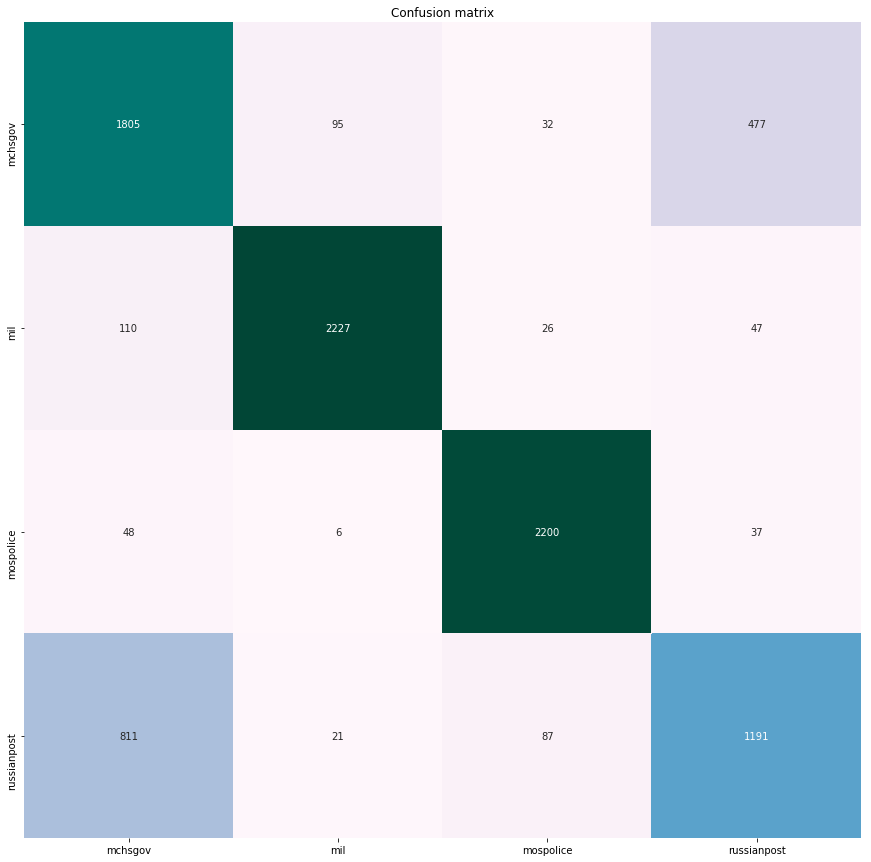

In [24]:
def display_word_distribution(model, feature_names, n_word):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        words = []
        for i in topic.argsort()[:-n_word - 1:-1]:
            words.append(feature_names[i])
        print(words)

traincorpus = [nostops(x) for x in train['lemmatizedtext']]
lda_model, feature_names, predictions = build_lda(traincorpus, train['source'], train['lemmatizedtext'])
display_word_distribution(
    model=lda_model, feature_names=feature_names,
    n_word=10)
    
cr = classification_report(train['source'], predictions)
print(cr)

lines = cr.split('\n')
classes = []
for line in lines[2 : (len(lines) - 5)]:
    t = line.split()
    classes.append(t[0])
    
m = confusion_matrix(train['source'], predictions)

labels = classes
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Задание 7 [4 балла]. Continious bag of words
Для baseline решения мы использовали обычное представление текста в виде мешка слов. Попробуйте использовать другие модели представления текста – например, в виде непрерывного мешка слов, то есть, в виде набора эмбеддингов. Для того, чтобы получить вектор текста попробуйте:
* усреднить все эмбеддинги слов, входящих в этот текст
* усреднить все эмбеддинги слов, входящих в этот текст с $tf-idf$ весами
* использовать любую модель эмбеддинга документа.

Используйте любую модель эмбеддингов по вашему вкусу. 

Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix).

I used GloVe embeddings. I trained a corpus (our train) to get the embeddings and then embedded our test set. To get our sentence embeddings I obtained the mean of every component of the vectors on the sentence space. We get then a single embedding with the same number of components for every sentence, and we can feed it to a classifier

In [15]:
sentlist = []
for text in train['lemmatizedtext']:
    sentlist.append(text)
open("glovemodel.txt", "w+", encoding="utf-8").write("\n".join(sentlist))

5892130

linux code here: <br>
./vocab_count -min-count 2 < glovemodel.txt > glovevocab.txt <br>
<br>
BUILDING VOCABULARY
Processed 776581 tokens.
Counted 42584 unique words.
Truncating vocabulary at min count 2.
Using vocabulary of size 18907. <br>
<br>
./cooccur -window-size 10 -vocab-file glovevocab.txt -memory 8.0
 < glovemodel.txt > glovecoocc.bin <br>
<br>
COUNTING COOCCURRENCES
window size: 10
context: symmetric
max product: 26461224
overflow length: 76056712
Reading vocab from file "glovevocab.txt"...loaded 18907 words.
Building lookup table...table contains 95332455 elements.
Processed 776580 tokens. 
Writing cooccurrences to disk........2 files in total.
Merging cooccurrence files: processed 4274521 lines. <br>
<br>
./shuffle -memory 8.0 < glovecoocc.bin > glovecoocc.shuf.bin <br>
<br>
SHUFFLING COOCCURRENCES
array size: 510027366
Shuffling by chunks: processed 4274521 lines.
Wrote 1 temporary file(s).
Merging temp files: processed 4274521 lines. <br>
<br>
./glove -input-file glovecoocc.shuf.bin -vocab-file glovevocab. <br>
<br>
xt -binary 2
TRAINING MODEL
Read 4274521 lines.
Initializing parameters...done.
vector size: 50
vocab size: 18907
x_max: 100.000000
alpha: 0.750000
iter: 001, cost: 0.023900
iter: 002, cost: 0.019624
...
iter: 024, cost: 0.007080
iter: 025, cost: 0.006960

In [6]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile, 'r', encoding="utf-8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

def vectorcalculator(test_sentences, loaded_model, df):
    finallist = np.zeros((df.shape[0], 50))
    for i, sentence in enumerate(test_sentences):
        sentencelist = []    
        for word in sentence.split():
            try:
                sentencelist.append(loaded_model[word])
            except:
                continue
        sentencelist = np.array(sentencelist)
        sentencelist = np.mean(sentencelist, axis = 0)
        if sentencelist.shape != (50,):
            sentencelist = np.zeros(50)
        finallist[i] = sentencelist
    return finallist

glovemodel = loadGloveModel(r"E:\Lorenzo Tosi\OneDrive - НИУ Высшая школа экономики\Documenti\Program\ML-for-compling\vectors.txt")


Loading Glove Model
Done. 18908  words loaded!


In [78]:
docemb = vectorcalculator(test['lemmatizedtext'].apply(nostops), glovemodel, test)
pca = PCA(n_components=10, random_state=10)
tsne = TSNE(random_state=10, init="pca")
clf = Pipeline([
('pca', pca),
('tsne', tsne),])
KM = KMeans(n_clusters = 4)
predictions = KM.fit_predict(clf.fit_transform(docemb, test['source']))

c:\users\lorenzo tosi\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\lorenzo tosi\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [79]:
test['predictions'] = predictions
print(test.groupby('source')['predictions'].value_counts())

c:\users\lorenzo tosi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


source       predictions
mchsgov      3              540
             2               38
             1               26
             0               13
mil          1              583
             2               10
             3               10
             0                1
mospolice    0              543
             1                8
             3                4
             2                3
russianpost  2              482
             0               25
             1               18
             3                2
Name: predictions, dtype: int64


In [87]:
#get list number from previous list
classdict = { 2 : "russianpost", 3 : "mchsgov", 1 : "mil", 0 : "mospolice" }
labels = ["mchsgov", "mil", "mospolice", "russianpost"]
results = []
for element in predictions:
    results.append(classdict[element])
test['predictions'] = results

c:\users\lorenzo tosi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


              precision    recall  f1-score   support

     mchsgov       0.88      0.97      0.92       556
         mil       0.97      0.92      0.94       635
   mospolice       0.97      0.93      0.95       582
 russianpost       0.91      0.90      0.91       533

   micro avg       0.93      0.93      0.93      2306
   macro avg       0.93      0.93      0.93      2306
weighted avg       0.93      0.93      0.93      2306



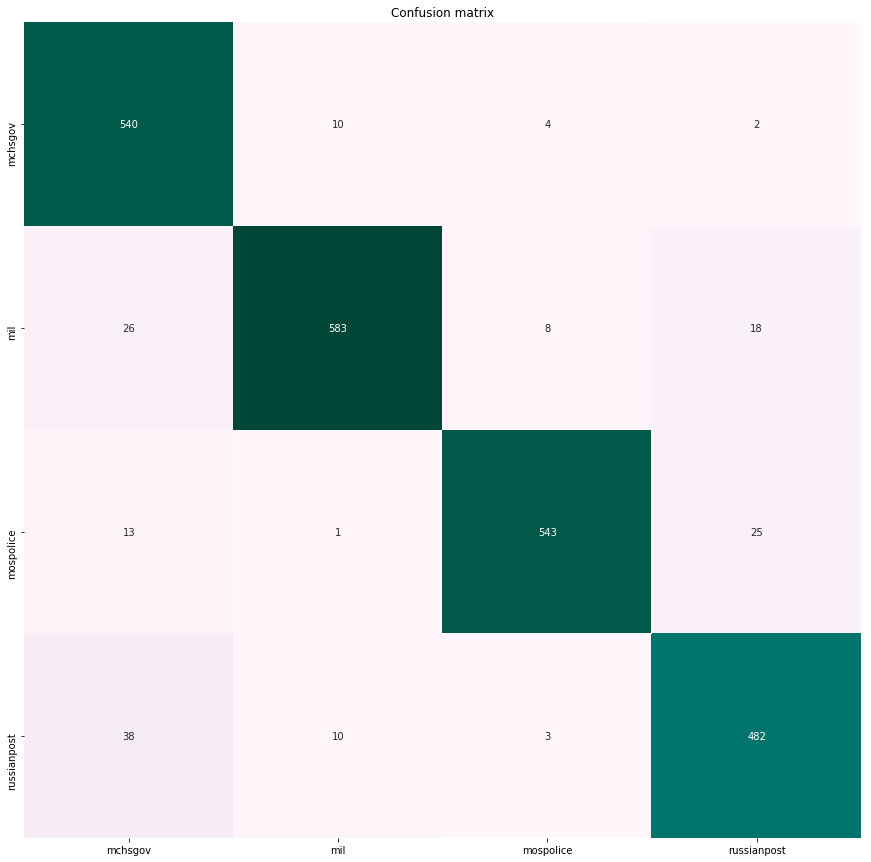

In [88]:
print(classification_report(test['predictions'], test['source']))
m = confusion_matrix(test['predictions'], test['source'])
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cbar=False, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Задание 8 [2 балла]. fastText

Используйте ```fastText``` в режиме классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix).

In [131]:
text = []
for row in train.iterrows():
    ourrow = "__label__" + str(row[1]['source']) + " " + str(row[1]['lemmatizedtext'])
    text.append(ourrow)
corpus = "\n".join(text)
with open ("fasttextmodel.txt", "w+", encoding="utf-8") as r:
    r.write(corpus)

./fasttext supervised -input ./hw1/fa
sttextmodel.txt -output ./hw1/classifier <br>
<br>
Read 0M words
Number of words:  42258
Number of labels: 4
Progress: 100.0% words/sec/thread:  412473 lr:  0.000000 loss:  0.382469 ETA:   0h 0m

In [19]:
classifier = fastText.load_model("./classifier.bin")
results = classifier.predict(test['lemmatizedtext'].tolist())
finalres = []
for element in results[0]:
    for string in element:
        finalres.append(string.lstrip("__label__"))

2306


              precision    recall  f1-score   support

     mchsgov       0.99      0.96      0.98       607
         mil       0.98      0.99      0.99       578
   mospolice       0.98      0.99      0.98       603
 russianpost       0.96      0.97      0.97       518

   micro avg       0.98      0.98      0.98      2306
   macro avg       0.98      0.98      0.98      2306
weighted avg       0.98      0.98      0.98      2306



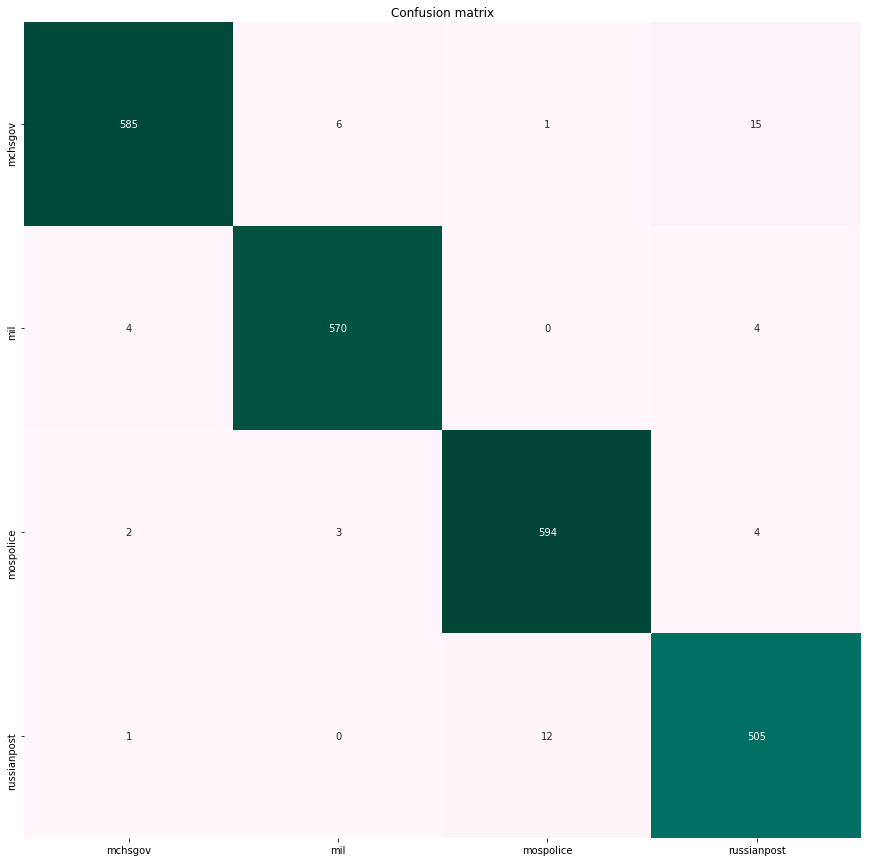

In [21]:
print(classification_report(test['source'], finalres))
m = confusion_matrix(test['source'], finalres)
labels = ["mchsgov", "mil", "mospolice", "russianpost"]
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cbar=False, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Конец
Подведите итоги и проведите сравнение всех использованных методов. Какой из них показался вам лучше и почему?

Fasttext seems the most viable method and the only one beating the baseline. This embeddings are able to catch more the semantic context that for russianpost and mchsgov were harder to catch (no fixed hastags, less structured text).  

**NB!** Задание обязательное вне зависимости от того, сколько из предыдущих пунктов вы выполнили, и дополнительных баллов не дает. 

# Правила сдачи 

1. Домашняя работа должна быть выполнена в ipynb-тетрадке под названием `ML_HW1.ipynb`.
2. Тетрадку можно загрузить либо на GitHub (и в таком случае лучше создать для домашек по курсу отдельный репозиторий), либо в Colab.
3. Ссылку на домашку нужно оставить [вот в этом опросе](https://goo.gl/forms/JpWWwKEZRkfy8OS02). 
4. Задание выполняется в группах 1-3 человека.
5. Все вычисления должны быть снабжены пояснениями!
6. Дедлайн – 3 марта в 10.00.

**NB!** Если вы даете ссылку на Colab, то обязательно делайте это через "Share", а не просто копируйте ее из адресной строки. 